<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/CN/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Decoding Neural Responses

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi,  Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom

---
# Setup


In [ ]:
# Imports
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [ ]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])

def plot_decoded_results(train_loss, test_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)
  # Plot the testing loss over iterations of GD
  ax1.plot(test_loss)
  ax1.legend(['train loss', 'test loss'])

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()

def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()

In [ ]:
# @title Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

---
# Section 1: Load and visualize data


23589 neurons in response to 360 stimuli


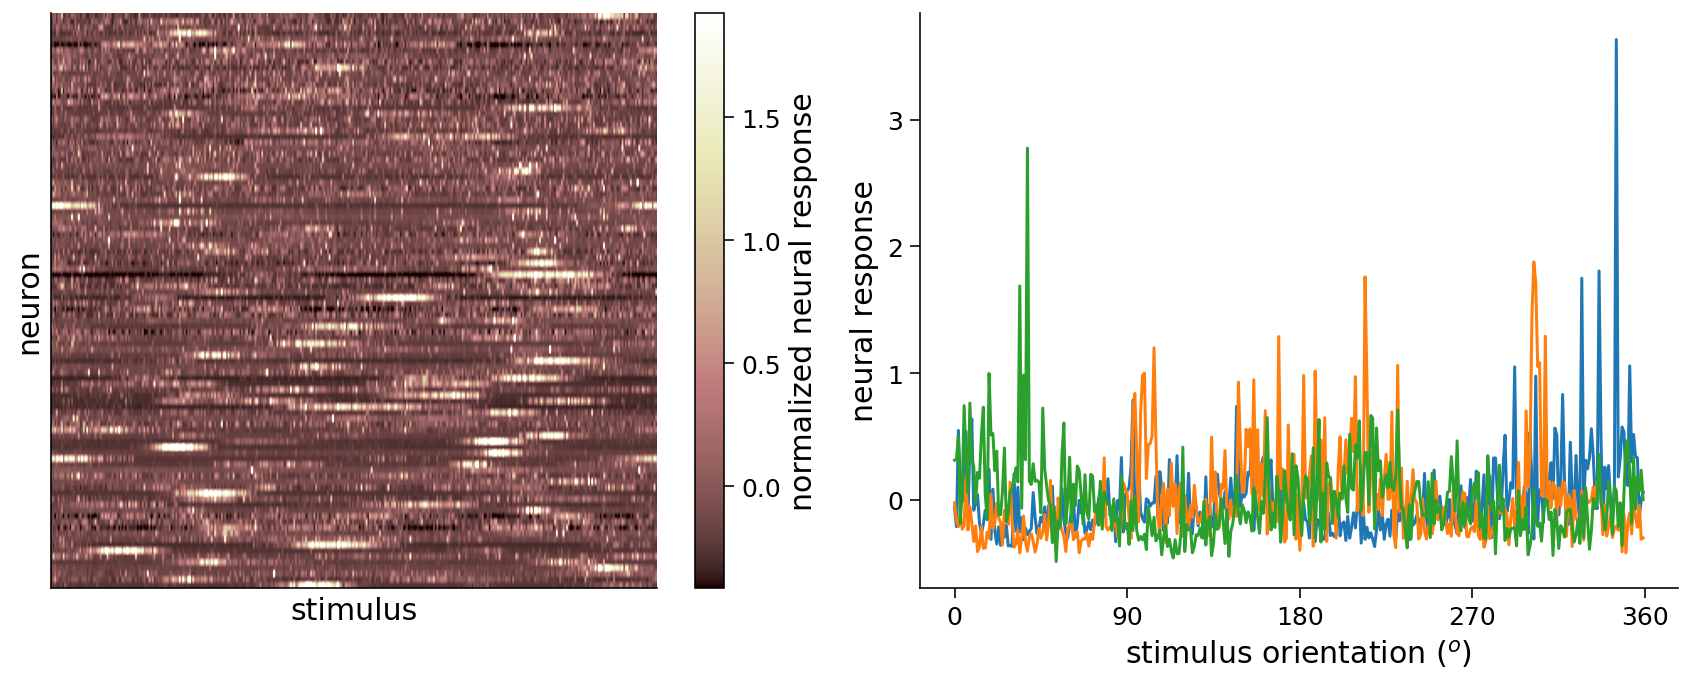

In [ ]:
#@title

#@markdown Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:, :100].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

In [ ]:
#@title
#@markdown Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

---
# Section 2: Deep feed-forward networks in *pytorch* 

In [ ]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

## Section 2.2: Activation functions

*Estimated timing to here from start of tutorial: 25 min* 

In [ ]:
class DeepNetReLU(nn.Module):
  """ network with a single hidden layer h with a RELU """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    h = torch.relu(self.in_layer(r)) # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)

    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNetReLU(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.17 degrees
true orientation: 139.00 degrees


---
# Section 3: Loss functions and gradient descent


In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(out, ori)

print('mean squared error: %.2f' % loss)

mean squared error: 42949.14


### Section 3.2: Optimization with gradient descent

In [ ]:
#@markdown Execute this cell to view gradient descent gif

from IPython.display import Image
Image(url='https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/grad_descent.gif?raw=true')

iteration 10/50 | loss: 12219.759
iteration 20/50 | loss: 1672.732
iteration 30/50 | loss: 548.097
iteration 40/50 | loss: 235.619
iteration 50/50 | loss: 144.001


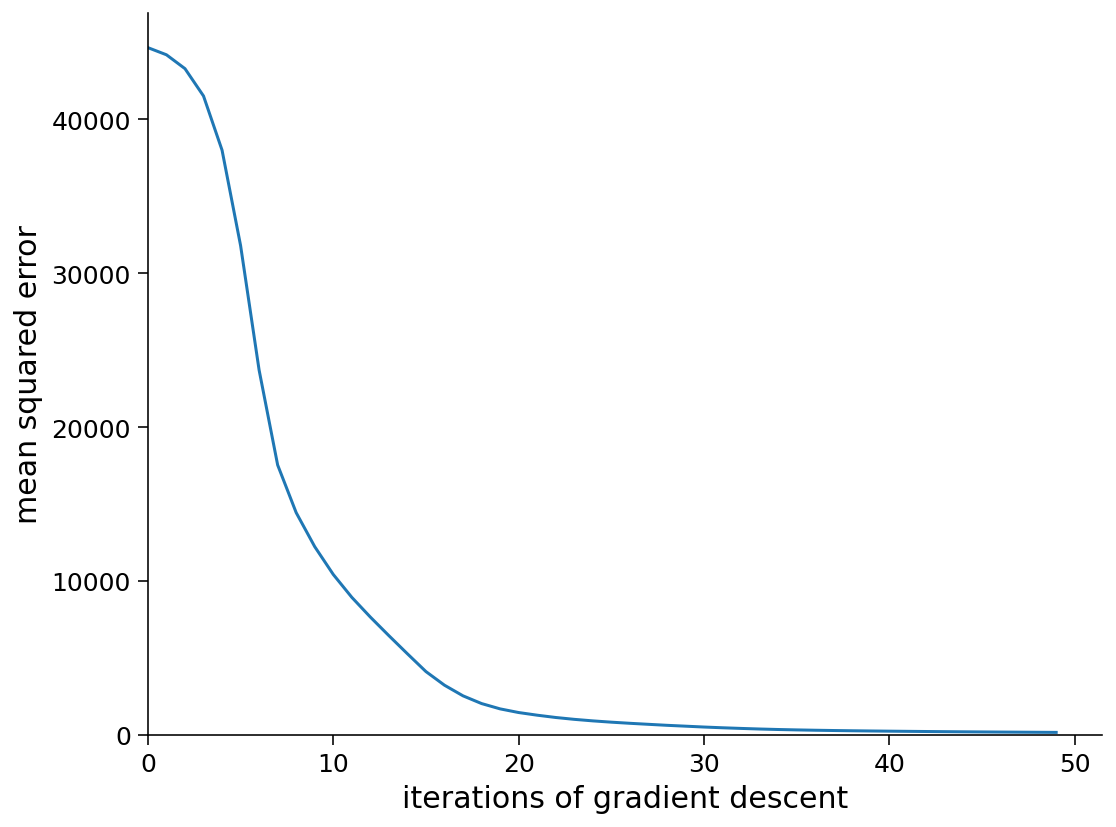

In [ ]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)